DATA ANALYSIS

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None

Missing Values:
Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

Descriptive Statistics:
         Sex       Length     Diameter       Height  Whole_weight  \
count

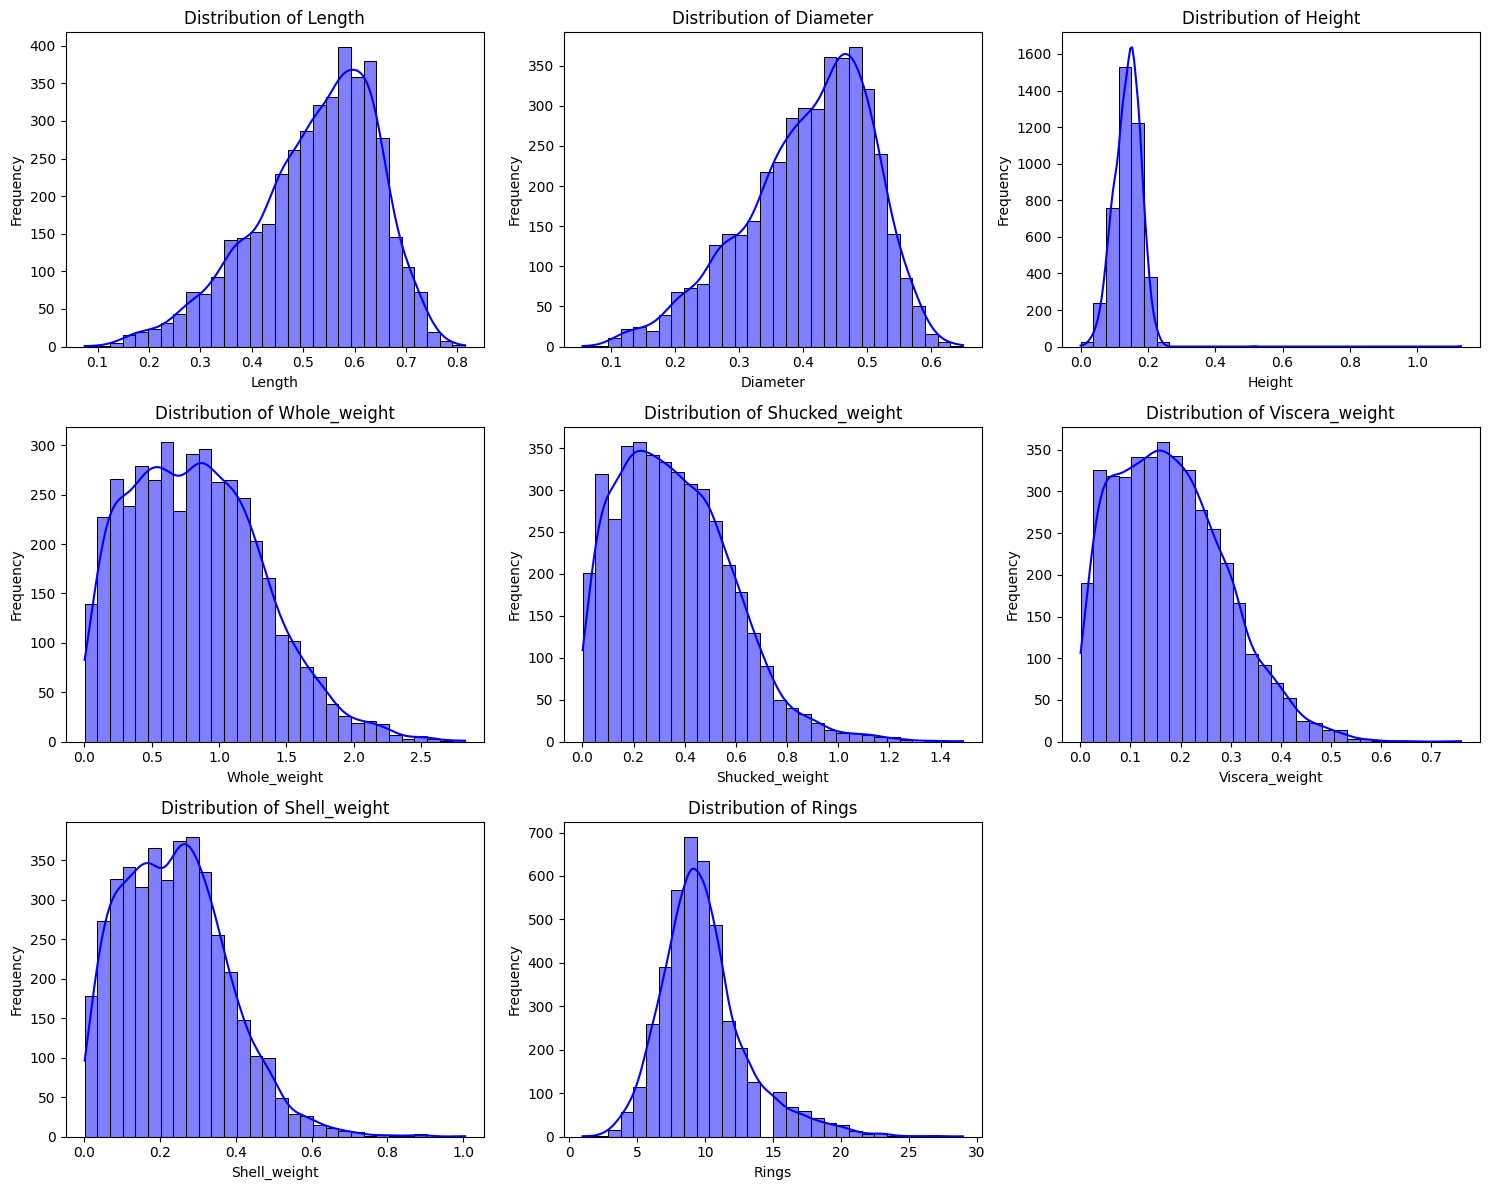

/var/folders/dw/d5q29pg93kl6s94t9g5z50780000gn/T/ipykernel_96604/4180084419.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["Sex"], palette="pastel")


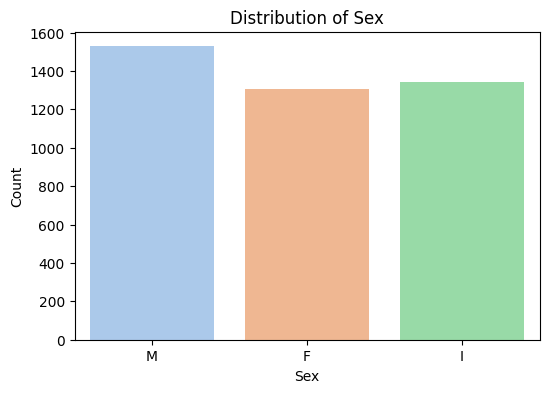

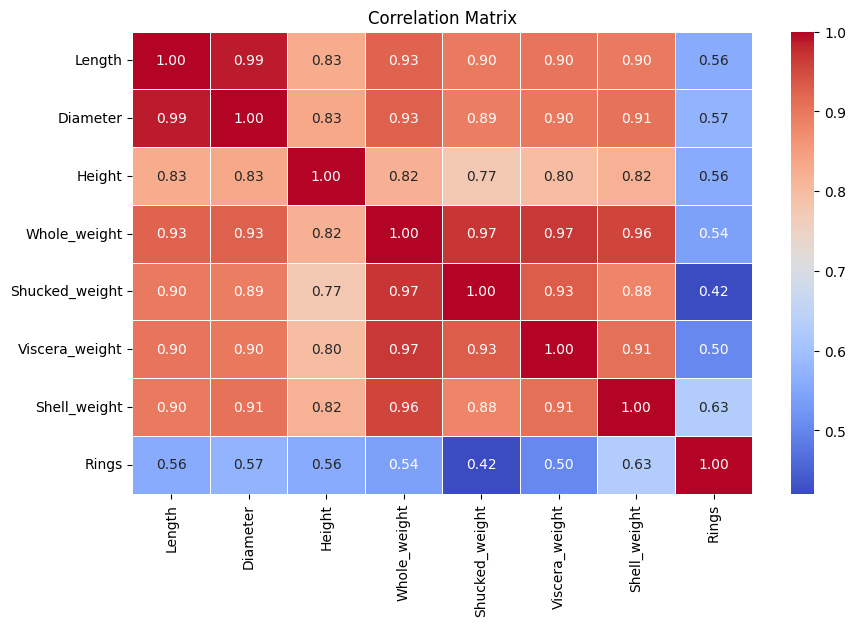

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# URL for the Abalone dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

columns = [
    "Sex", "Length", "Diameter", "Height",
    "Whole_weight", "Shucked_weight", "Viscera_weight",
    "Shell_weight", "Rings"
]

data = pd.read_csv(url, header=None, names=columns)

print("Dataset Information:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())


print("\nDescriptive Statistics:")
print(data.describe(include="all"))

numerical_columns = [
    "Length", "Diameter", "Height", "Whole_weight",
    "Shucked_weight", "Viscera_weight", "Shell_weight", "Rings"
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for idx, column in enumerate(numerical_columns):
    sns.histplot(data[column], bins=30, kde=True, ax=axes[idx], color="blue")
    axes[idx].set_title(f"Distribution of {column}")
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel("Frequency")


axes[-1].axis("off")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
sns.countplot(x=data["Sex"], palette="pastel")
plt.title("Distribution of Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

numeric_data = data.select_dtypes(include=['number']) 
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


EXPERIMENTING & MODEL COMPARISON

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

data = pd.read_csv("abalone.data", header=None, names=[
    "Sex", "Length", "Diameter", "Height",
    "Whole_weight", "Shucked_weight", "Viscera_weight",
    "Shell_weight", "Rings"
])

# Preprocessing
# Encode Sex (categorical variable)
data = pd.get_dummies(data, columns=["Sex"], drop_first=True)
# Binning Rings (target variable) into classes
data["Rings"] = pd.cut(data["Rings"], bins=[0, 8, 15, 30], labels=[0, 1, 2])

X = data.drop("Rings", axis=1)
y = data["Rings"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "k-NN": KNeighborsClassifier()
}

param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10, 20]
    },
    "Decision Tree": {
        "max_depth": [None, 5, 8, 10, 15],
        "criterion": ["gini", "entropy"]
    },
    "Naive Bayes": {},  # No hyperparameters for GaussianNB
    "k-NN": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "metric": ["euclidean", "manhattan"]
    }
}

# Grid Search
best_models = {}
for model_name, model in models.items():
    grid = GridSearchCV(model, param_grids.get(model_name, {}), cv=5, scoring="f1_weighted")
    grid.fit(X_train_scaled, y_train)
    best_models[model_name] = grid.best_estimator_
    print(f"Best Parameters for {model_name}: {grid.best_params_}")

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"])

for model_name, model in best_models.items():
    # Evaluate on Test Set
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # ROC-AUC
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_scaled)
        roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr", average="weighted")
    else:
        roc_auc = None

    results = pd.concat([results, pd.DataFrame([{
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }])], ignore_index=True)

print("\nModel Comparison:")
print(results)


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 20, 'n_estimators': 300}
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5}
Best Parameters for Naive Bayes: {}
Best Parameters for k-NN: {'metric': 'euclidean', 'n_neighbors': 11}

Model Comparison:
           Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Random Forest  0.779904   0.764558  0.779904  0.761023  0.866536
1  Decision Tree  0.783493   0.780905  0.783493  0.763363  0.853882
2    Naive Bayes  0.714115   0.720816  0.714115  0.714005  0.804652
3           k-NN  0.779904   0.762636  0.779904  0.759835  0.845214


/var/folders/dw/d5q29pg93kl6s94t9g5z50780000gn/T/ipykernel_96604/1623083083.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{
